# Code Matlab

In [70]:
# clear;
# clc;
# format long e    % çà ce n'est pas intelligent, la constante d'Euler c'est e dans Matlab: change de nom!

# L = 1.0;  % longueur du lit
# ug = 0.01; % vitesse spécifique de gaz
# epsb = 0.5; % porosité du lit
# kg = 0.0001; % coefficient de transfert
# Ke = 10;  % coeff d'équilibre
# dp = 0.005;   % diamètre de particule
# as = 6*(1-epsb)/dp;  % surface spécifique, dépend du diamètre de la sphère
# tend = 1000;  % fin du temps de simulation

# % il n'y a pas de dispersion axiale

# N = 100;
# M = 5;
# x = linspace(0, L, N+1);   % sépare le tube en N+1 compartiments de même longueur
# t = linspace(0, tend, M+1);  % sépare le temps en 6 moments de même durée; çà me semble bien court pour une dynamique...

# figure, hold on
# title('Analytical solution:')
# xlabel('x/L [-]');
# h = legend('show','location','best');
# set(h,'FontSize',12);
# for j=2:M+1
#     for i=1:N+1
#         tau = kg*as/((1-epsb)*Ke)*(t(j) - x(i)/ug);  % donne le \tau de la correction pour chaque x et L
#         xi = kg*as/(epsb*ug)*x(i);  % pareil avec le \xi
#         fnc = @(u) exp(-u).*besseli(0, sqrt(4*tau*u), 1)./exp(-abs(real(sqrt(4*tau*u))));  % scales besseli function to avoid overflow
#         I = integral(fnc, 0 , xi); % integral in the solution
#         e = exp(-tau); % no comment
#         g = besseli(0, sqrt(4*tau*xi))*exp(-xi); % la deuxième partie dans le Cs
#         Cg(i) = real(1 - e*I);   % donne le Cg, normalisé par Cg_in
#         Cs(i) = real(Ke*(1 - e*(I + g))); % pareil pour Cs
#     end
#     Cg(isinf(Cg)) = 0;
#     Cs(isinf(Cs)) = 0;

#     subplot(2,1,1), hold on
#     yyaxis left, hold on
#     plot(x/L,Cg,'-x','LineWidth',1,'MarkerSize',1,'DisplayName',num2str(t(j)))
#     ylabel('Cg/Cgin [-]');
#     ylim([0 1]);

#     yyaxis right, hold on
#     subplot(2,1,2), hold on
#     plot(x/L,Cs,'-x','LineWidth',1,'MarkerSize',1,'DisplayName',num2str(t(j)))
#     ylabel('Cs/Cgin [-]');
#     ylim([0 Ke]);
# end

# Attempt - PINN in python

## Chargement package

In [71]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [72]:
# !pip install tensorflow
# !pip install deepxde

In [73]:
import numpy as np
from deepxde.backend import tf
import deepxde as dde
import matplotlib.pyplot as plt

In [74]:
L = 1.0;            # longueur du lit
ug = 0.01;          # vitesse spécifique de gaz
epsb = 0.5;         # porosité du lit
kg = 0.0001;        # coefficient de transfert
Ke = 10;            # coeff d'équilibre
dp = 0.005;         # diamètre de particule
as_ = 6*(1-epsb)/dp; # surface spécifique, dépend du diamètre de la sphère

## Partial Differential Equations

In [75]:
def pde(z, u):
    cs, cg = u[:, 0:1], u[:, 1:2]

    dcg_z = dde.grad.jacobian(u, z, i=1, j=0)
    dcg_t = dde.grad.jacobian(u, z, i=1, j=1)
    dcs_t = dde.grad.jacobian(u, z, i=0, j=1)

    # dcg_z = dde.grad.jacobian(u, z, i=0, j=0)
    # dcg_t = dde.grad.jacobian(u, z, i=0, j=1)
    # dcs_t = dde.grad.jacobian(u, z, i=1, j=1)

    eq1 = (dcg_t + ug * dcg_z) + (kg*as_/epsb) * (cg-cs/Ke)
    eq2 = dcs_t - (kg*as_/(1-epsb)) * (cg-cs/Ke)

    return [eq1, eq2]

In [76]:
def cs_func(x):
  return 0

def cg_func(x):
  if (x.all()!=0):
    return 0
  else:
    return 1



## Spécification des dimensions (z,t)

In [77]:
# Pas de calcul (0.1) ?
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 4.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

## Initial Condition & Boundary Condition

### IC

In [78]:
ic_cs = dde.icbc.IC(geomtime, lambda cs: 0, lambda _, on_initial: on_initial, component=0)
ic_cg = dde.icbc.IC(geomtime, lambda cg: 1, lambda _, on_initial: on_initial, component=1)

### BC

In [79]:
bc_cs = dde.icbc.DirichletBC(geomtime, cs_func, lambda _, on_boundary: on_boundary)
bc_cg = dde.icbc.DirichletBC(geomtime, cg_func, lambda _, on_boundary: on_boundary)

## Combinaison de tous les paramètres définis

In [80]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_cs, bc_cg, ic_cs, ic_cg],
    num_domain=2540,
    num_boundary=80,
    num_initial=160
)

## Construction réseaux de neurones

In [81]:
layer_size = [2] + [50] * 4 + [2]
activation = "tanh"
initializer = "Glorot normal"

net = dde.nn.FNN(layer_size, activation, initializer)

## Apprentissage du modèle

In [82]:
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
losshistory, train_state = model.train(iterations=10000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.095170 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 0.820944 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [4.94e-03, 3.69e-04, 1.92e-03, 9.26e-01, 1.61e-03, 6.35e-01]    [4.94e-03, 3.69e-04, 1.92e-03, 9.26e-01, 1.61e-03, 6.35e-01]    []  
1000      [1.75e-04, 2.87e-03, 2.35e-01, 2.73e-01, 9.78e-03, 7.03e-05]    [1.75e-04, 2.87e-03, 2.35e-01, 2.73e-01, 9.78e-03, 7.03e-05]    []  
2000      [4.64e-05, 2.53e-03, 2.36e-01, 2.69e-01, 6.97e-03, 2.99e-05]    [4.64e-05, 2.53e-03, 2.36e-01, 2.69e-01, 6.97e-03, 2.99e-05]    []  
3000      [5.21e-05, 1.98e-03, 2.38e-01, 2.66e-01, 6.64e-03, 5.66e-06]    [5.21e-05, 1.98e-03, 2.38e-01, 2.66e-01, 6.64e-03, 5.66e-06]    []  
4000      [5.05e-05, 1.97e-03, 2.43e-01, 2.61e-01, 5.99e-03, 1.44e-05]    [5.05e-05, 1.97e-03, 2.43e-01, 2.61e-01, 5.99e-03, 1.44e-05]    []  
5000      [3.21e-05, 1.67e-03, 2.08e-01, 2.99e-01, 4.11e-03, 5.22e-05]    [3.21e-05, 1.67

## Affichage des résultats

<Figure size 2000x1200 with 0 Axes>

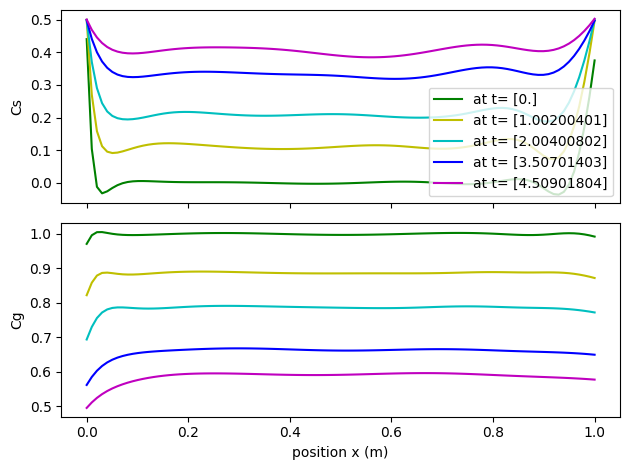

In [83]:
x = np.linspace(0, int(L), num = int(L) * 100)
x = np.reshape(x, (-1, 1))
t = np.linspace(0, 5, num = 500)
t = np.reshape(t, (-1, 1))

color = ['g', 'y', 'c', 'b', 'm', 'r', 'k']
line = ['-', '--', '-.']
line_idx = 0

T = [0, 100, 200, 350, 450]

plt.figure(figsize=(20, 12))
color_idx = 0

# Create two subplots (two axes) within the same figure
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)  # Two subplots stacked vertically

for idx_time in T:
    x_t = [[0, 0]]
    x_t = np.append(x_t, np.insert(x, 1, t[idx_time][0], axis=1), axis=0)
    x_t = x_t[1:]

    # Predict both sets of data
    y_pred = model.predict(x_t)

    ax1.plot(
        x_t[:, 0],
        y_pred[:, 0],  # First output
        color=color[color_idx % 7],
        linestyle=line[line_idx],
        label="at t= " + str(t[idx_time])
    )

    ax2.plot(
        x_t[:, 0],
        y_pred[:, 1],  # Second output
        color=color[color_idx % 7],
        linestyle=line[line_idx],
        label="at t= " + str(t[idx_time])
    )

    color_idx += 1

# Set labels for both axes
ax1.set_ylabel("Cs")
ax2.set_ylabel("Cg")
ax2.set_xlabel("position x (m)")

# Add a legend
ax1.legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Sauvegarde

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


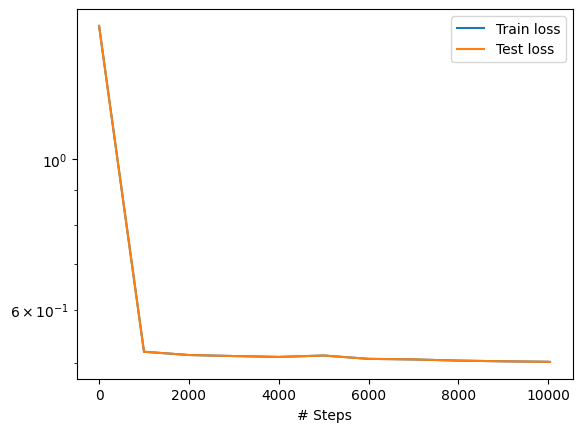

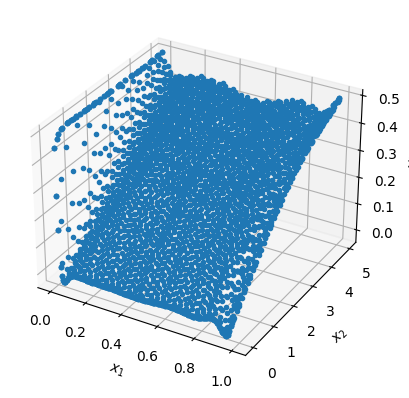

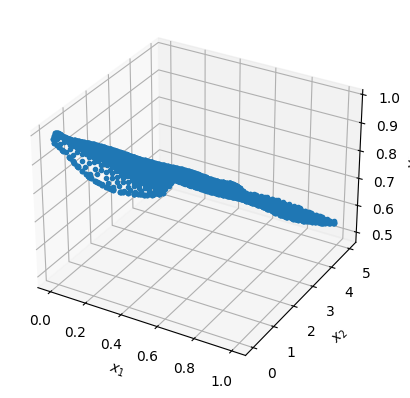

In [84]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)